<a href="https://colab.research.google.com/github/supsi-dacd-isaac/teaching/blob/main/2021SmartGrids/L05_Power_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Flow Simulations
In this lecture we will solve a power flow for the following circuit

<center><img src="https://github.com/supsi-dacd-isaac/teaching/raw/main/2021SmartGrids/figs/load_flow_circuit.png" width="600"></center>

using the Gauss-Seidel method.

We know the impedances of the lines:
$$
\begin{array}{l}
Z_1 = 0.05 + 0.1j\\
Z_2 = 0.05 + 0.05j\\
Z_3 = 0.15 + 0.2j\\
Z_4 = 0.04 + 0.12j
\end{array}
$$

Let us further assume that buses 1 and 2 are generators with the ability to modulate their reactive power. We then consider the modulus of their voltages to be constant and equal to :
$$
\begin{array}{l}
V1 = 1.05 \mathrm{pu}\\
V2 = 1.00 \mathrm{pu}\\
\end{array}
$$
And their active powers $P_1,P_2 = 1  \mathrm{pu}$

Let us assume that Buses 3 and 4 are loads. Let us consider their potentials (complex vectors) unknown, and let us consider their powers known:
$$
\begin{array}{l}
P3 = -0.9 \mathrm{pu}, Q3 = 0 \mathrm{pu}\\
P4 = -1 \mathrm{pu}, Q4 = -0.2 \mathrm{pu}\\
\end{array}
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

Let's define the grid parameters in terms of the m line impedances, and plot them as complex vectors.

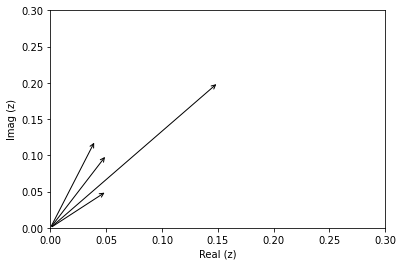

In [ ]:
z =np.array([.05 + .1j, 
             .05 + .05j, 
             .15 + .2j, 
             .04 + .12j])

fig, ax = plt.subplots(1, 1)
[ax.annotate('', xy=(x.real, x.imag), xytext=(0, 0), arrowprops=dict(arrowstyle="->")) for i, x in enumerate(z)]
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.xlabel('Real (z)')
plt.ylabel('Imag (z)');

The second element we need to characterize our grid is the incidence matrix I, having n rows and m columns, where n is the number of nodes in the grid and m the number of branches. The incidence matrix is an alternative to the adiacence matrix to describe the topology of the grid. We can plot the resulting connections using networkx.

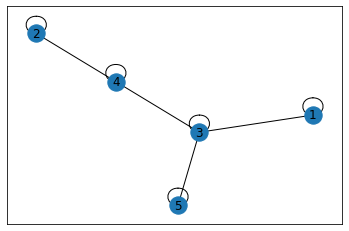

In [ ]:
incidence =np.asanyarray([[1,  0,  0,  0],
            [0,  0,  0,  1],
            [-1,  1, -1,  0],
            [0,  0,  1, -1],
            [0, -1,  0,  0]], dtype=int)

incidence_abs = np.abs(incidence)
adiacency = incidence_abs @ incidence_abs.T
graph = nx.from_numpy_matrix(adiacency)
graph = nx.relabel_nodes(graph, lambda x: x+1)

positions = nx.kamada_kawai_layout(graph)
nx.draw_networkx(graph, pos=positions)

In [ ]:
# let's define vectors of known voltages magnitudes and angles 
VNM = np.array([1.05, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)
VNA = np.array([0, 0, 0, 0, 0], dtype=bool).reshape(-1, 1)

# let's create boolean vectors indicating which voltage magnitudes and angles 
# are to use in the error checking phase of the iterations 
KNM = np.array([1, 1, 0, 0, 1], dtype=bool).reshape(-1, 1)
KNA = np.array([0, 0, 0, 0, 1], dtype=bool).reshape(-1, 1)

# let's define known active and reactive powers, and put 0 if they're not known
P = np.array([1, 1, -.9, -1, 0]).reshape(-1, 1)
Q = np.array([0, 0, 0, -.2, 0]).reshape(-1, 1)

# let's create boolean vectors indicating which active and reactive powers 
# are to use in the error checking phase of the iterations 
PC = np.array([1, 1, 1, 1, 0]).reshape(-1, 1)
QC = np.array([0, 0, 1, 1, 0]).reshape(-1, 1)


# we then define KUM and KUA boolean vectors to indicate the unknown quantities
KUM = ~KNM
KUA = ~KNA



We can now define the admittance matrix from the line admittance matrix.

In [ ]:
Y = np.diag(1/z)
YN = incidence @ Y @ incidence.T # <------- fill this
print(YN)

[[  4.  -8.j    0.  +0.j   -4.  +8.j    0.  +0.j    0.  +0.j ]
 [  0.  +0.j    2.5 -7.5j   0.  +0.j   -2.5 +7.5j   0.  +0.j ]
 [ -4.  +8.j    0.  +0.j   16.4-21.2j  -2.4 +3.2j -10. +10.j ]
 [  0.  +0.j   -2.5 +7.5j  -2.4 +3.2j   4.9-10.7j   0.  +0.j ]
 [  0.  +0.j    0.  +0.j  -10. +10.j    0.  +0.j   10. -10.j ]]


### Load flow solutions
In order to retrieve a good solution for the power flow, we must pick reasonable starting values for the nodal voltages and angles. Even if the algorithm that we're gonna use is guaranteed to converge, the final solution isn't guaranteed to be the correct one. Generally speaking, we can choose voltage values close to unity since we are solving the power flow in per unit, and we can choose small deviations for the voltage angles. 

In [ ]:
# starting values for voltages' magnitudes and angles
VM = np.array([1.05, 1, .99, .99, 1]).reshape(-1, 1)
VA = np.array([.02, .01, .01, .02, 0]).reshape(-1, 1)

In [ ]:
def solve_lf(NI,YN,VM,VA,VNM,VNA,KNM,KNA,P,Q,PC,QC, tol=1e-6):
  """
  Solve approximated load flow
  """

  # unknown variables vectors
  KUM = ~KNM
  KUA = ~KNA

  # error initialization
  Error = 1
  N = len(VNM)

  # current iteration voltage vectors, combining known and unknown values

  VMAG = VNM * KNM + VM * KUM
  VANG = VNA * KNA + VA * KUA

  # complex voltage
  V = VMAG * np.exp(1j * VANG);

  # counter initialization 
  r=1;
  Errors = []

  while Error>tol:

    for i in range(N): # iterate over all nodes
        # the solution method depends on the node type
        if (KUM[i] == 1) and (KUA[i] == 1): # if it's a load
            pvc= (P[i]-1j * Q[i]) / np.conj(V[i])
            for n in range(N):
                if n !=i: 
                    pvc = pvc - (YN[i,n] * V[n]) 
            V[i] = pvc/YN[i,i]
        elif (KUM[i] == 0) and (KUA[i] == 1): # if it's a generator
            Qn = np.imag(V[i] * np.conj(YN[[i],:] @ V))
            pvc= (P[i] - 1j * Qn) / np.conj(V[i])
            for n in range(N):
                if n !=i: 
                    pvc = pvc - (YN[i,n] * V[n])
            pv=pvc/YN[i,i]
            V[i] = VM[i] @ np.exp(1j * np.angle(pv))

    # recompute nodal currents 
    I = (YN@V)

    # recompute powers
    PI = np.real(V * np.conj(I));
    QI = np.imag(V * np.conj(I));

    # let's recompute current solutions' distances from known quantities
    PERR = (P-PI) * PC
    QERR = (Q-QI) * QC
    Error = np.sum(np.abs(PERR)**2 + np.abs(QERR)**2)
    Errors.append(Error)
    r=r+1
    if r%2==0:
      plt.figure()
      nx.set_node_attributes(graph, {k:v.real for k, v in zip(graph.nodes, np.abs(V).ravel())}, 'v')
      nx.draw_networkx(graph, node_color=list(nx.get_node_attributes(graph, 'v').values()), pos=positions)
  DVline = NI.T @ V;
  I = YN @ V
  Iline = Y @ DVline
  Sloss = DVline * np.conj(Iline)
  return V,P,Q,I,DVline,Iline,Sloss, Errors

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


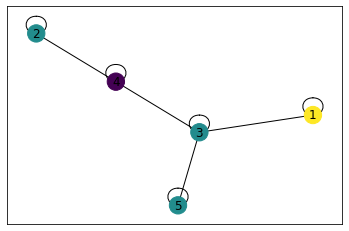

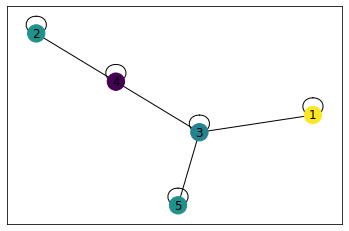

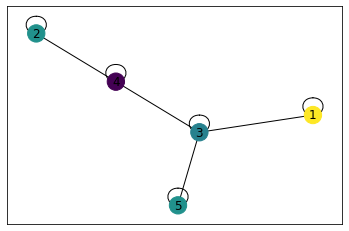

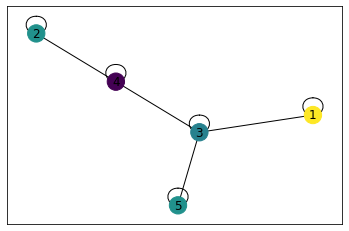

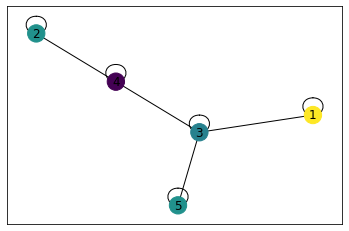

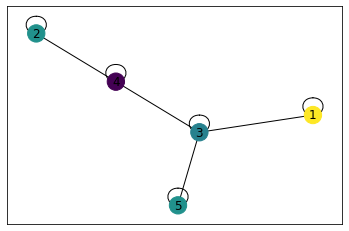

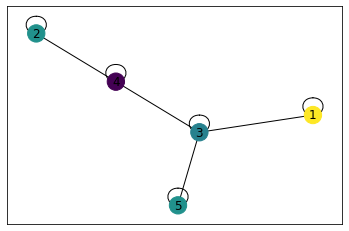

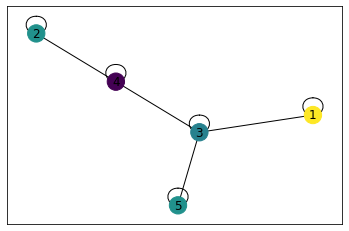

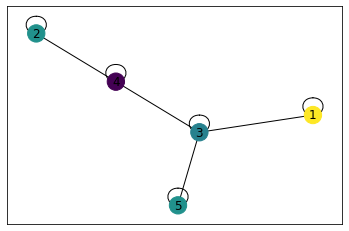

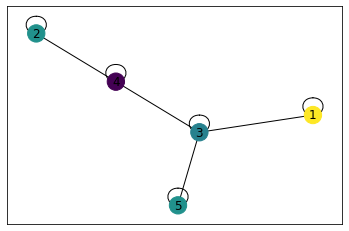

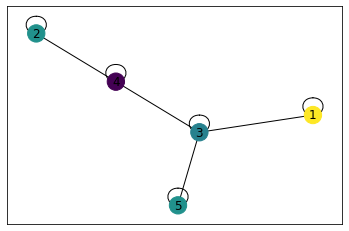

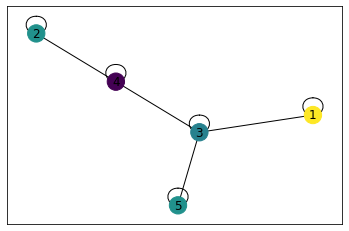

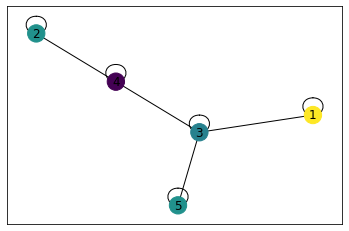

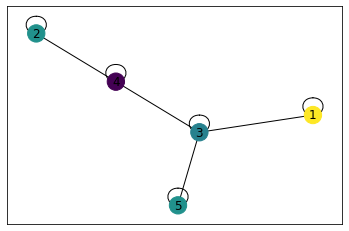

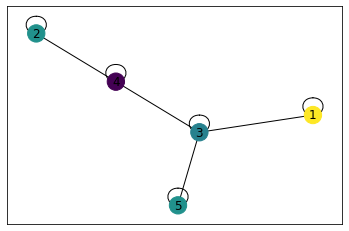

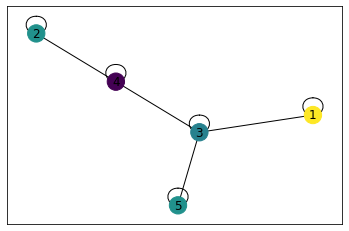

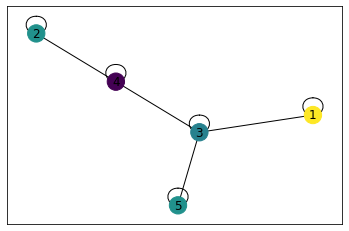

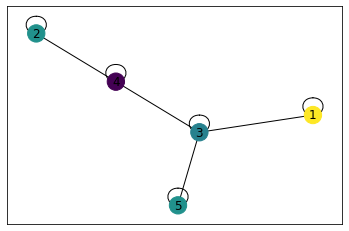

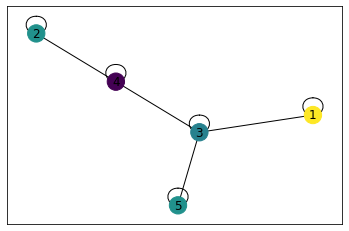

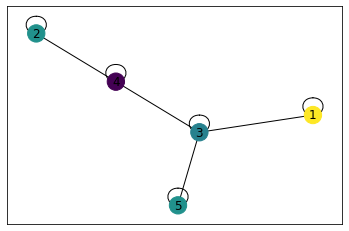

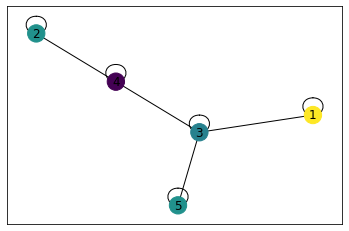

In [ ]:
V,P,Q,I,DVline,Iline,Sloss, errs = solve_lf(incidence, YN,VM,VA,VNM,VNA,KNM,KNA,P,Q,PC,QC, tol=1e-12)

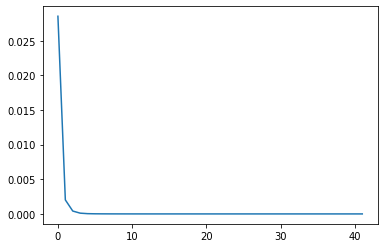

In [ ]:
plt.plot(errs)

In [ ]:
nx.get_node_attributes(graph, 'v')

{1: 1.0499999999999998,
 2: 1.0,
 3: 0.993315122738558,
 4: 0.9494108133126797,
 5: 1.0}